# Wine Score Prediction

## Setup

Import of necessary Python libraries.

In [141]:
!python -m pip install xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy import stats
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler, QuantileTransformer 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve, auc, average_precision_score, f1_score, roc_curve
from sklearn.decomposition import PCA
import xgboost as xgb
sns.set()
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, KBinsDiscretizer
from scipy.stats import boxcox
from sklearn.ensemble import IsolationForest

seed = 42

In [3]:
# optional: improves readibility by displaying all columns 
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

In [4]:
df = pd.read_csv("wines.csv")

In [5]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Spain,Unusual aromas of cardamom and cinnamon accent...,Vendimia Seleccionada,86,13.00,Northern Spain,Rioja,NaN,Michael Schachner,@wineschach,Bodegas Riolanc 2012 Vendimia Seleccionada (R...,Tempranillo Blend,Bodegas Riolanc
1,US,"A full load of berry fruit in the nose, black-...",NaN,92,78.00,California,Napa Valley,Napa,NaN,NaN,Clark-Claudon 1997 Cabernet Sauvignon (Napa Va...,Cabernet Sauvignon,Clark-Claudon
2,Canada,"A lush fruit bowl of a wine, this brings delic...",NaN,90,19.00,British Columbia,Okanagan Valley,NaN,Paul Gregutt,@paulgwine,Tinhorn Creek 2013 Pinot Gris (Okanagan Valley),Pinot Gris,Tinhorn Creek
3,US,"This offers fresh flavors of pear fruit, with ...",NaN,86,12.00,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Château Bianca 2015 Pinot Gris (Willamette Val...,Pinot Gris,Château Bianca
4,US,This is a good Zinfandel with some special qua...,NaN,87,34.00,California,Sonoma County,Sonoma,NaN,NaN,Adobe Road 2005 Zinfandel (Sonoma County),Zinfandel,Adobe Road


## Exploratory Data Analysis

#### Irrelevant features

In [6]:
# df.drop(["taster_name", "taster_twitter_handle"], axis=1, inplace=True)

#### Duplicates

In [7]:
df.drop_duplicates(inplace=True)

**Data types**

In [8]:
df.dtypes.sort_values()

points                     int64
price                    float64
country                   object
description               object
designation               object
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

## Univariate Statistical Analysis

In [9]:
len(df)

91920

In [10]:
df.count()

country                  91874
description              91920
designation              65405
points                   91920
price                    85513
province                 91874
region_1                 76969
region_2                 35784
taster_name              72985
taster_twitter_handle    69515
title                    91920
variety                  91920
winery                   91920
dtype: int64

### Basic descriptive statistic on numerical features

In [11]:
df.describe()

,points,price
count,91920.00,85513.00
mean,88.44,35.57
std,3.08,41.89
min,80.00,4.00
25%,86.00,17.00
50%,88.00,25.00
75%,91.00,42.00
max,100.00,3300.00


### Missing values

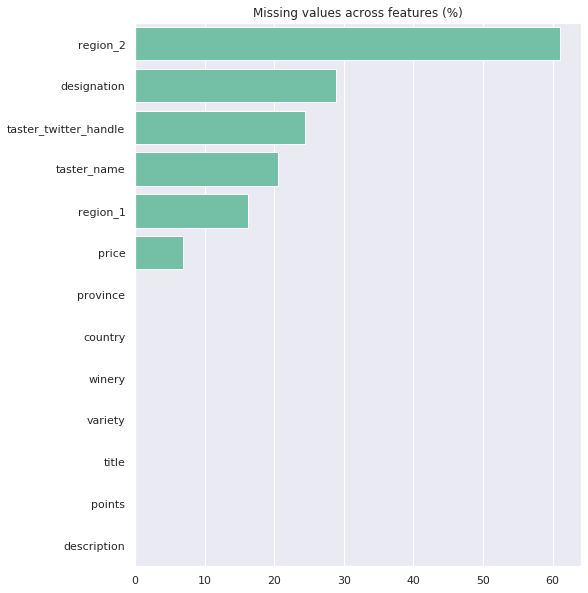

In [12]:
# Check for columns with missing values
plt.figure(figsize=(8, 10))
missing_vals = df.isnull().sum().sort_values(ascending=False) 
sns.barplot(x=missing_vals / len(df) * 100, y=missing_vals.index, orient="h", color="mediumaquamarine")
plt.title("Missing values across features (%)");

### Data distribution 

**Target variable**

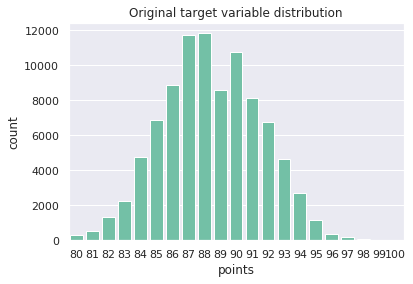

In [20]:
sns.countplot(x="points", data=df, color="mediumaquamarine") 
plt.title('Original target variable distribution');

**Numeric features**

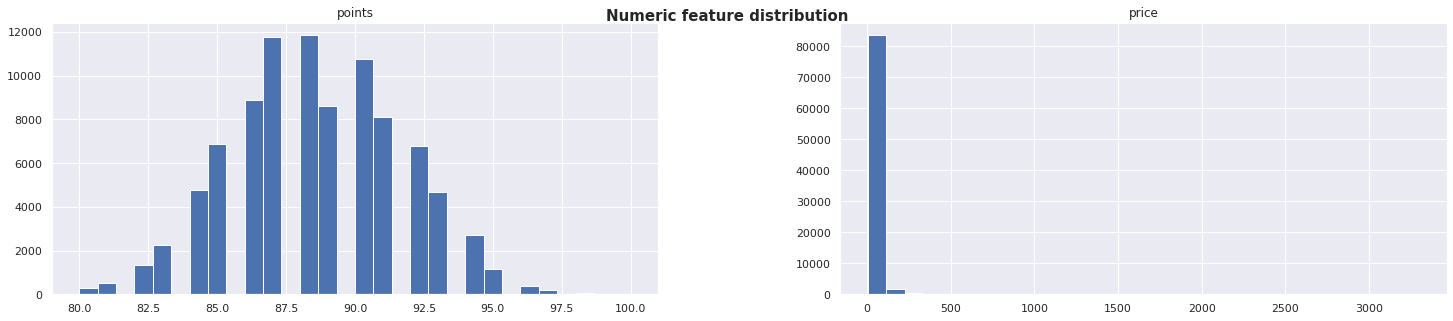

In [21]:
df.hist(bins=30, figsize=(25, 5))
plt.suptitle("Numeric feature distribution", fontweight='bold', fontsize=15, y=0.92);

In [22]:
numeric_cols = df.select_dtypes(exclude=['object'])
for feature in numeric_cols:
    q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
    iqr = q75 - q25
    cutoff = iqr * 1.5
    lower, upper = q25-cutoff, q75+cutoff
    
    outliers_idx = np.where((df[feature] < lower) | (df[feature] > upper)) 
    outliers = df.iloc[outliers_idx]
    
    print(f'{feature}: {len(outliers)} outliers')

points: 41 outliers
price: 0 outliers


**Catagorical features**

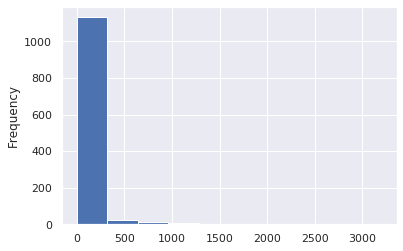

In [165]:
df['region_1'].value_counts().plot(kind='hist')

## Multivariate Statistical Analysis

### Correlation  between numerical features

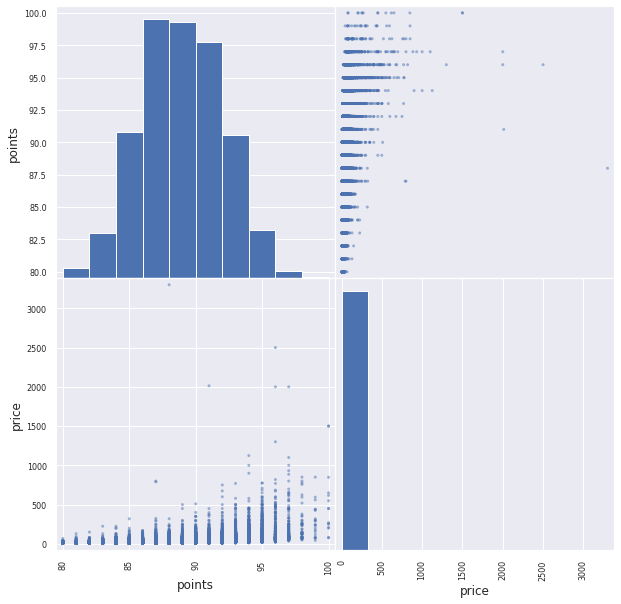

In [167]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


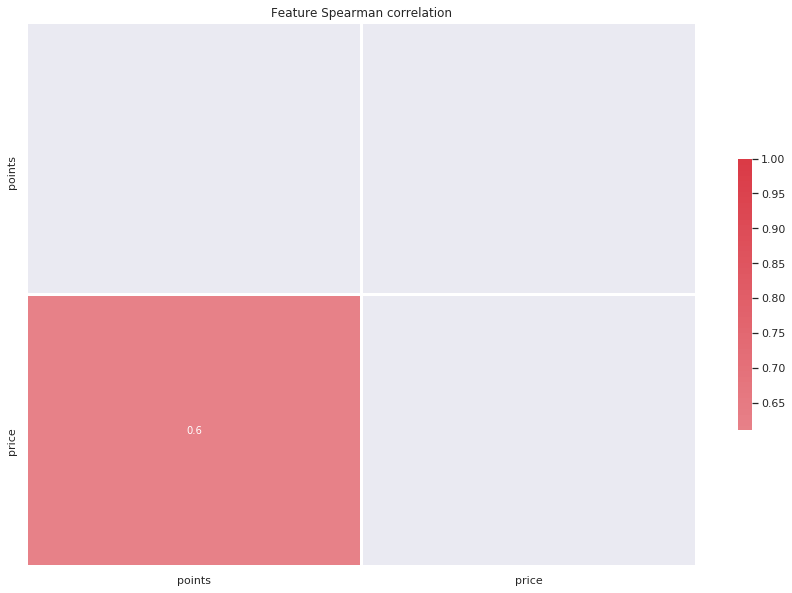

In [168]:
plt.figure(figsize=(15,10))

corr = df.corr(method="spearman")

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"fontsize":10},
            fmt=".1", linewidths=2, cbar_kws={"shrink": 0.5})
plt.title("Feature Spearman correlation")
plt.show()

### Export data

In [169]:
df.to_csv('/root/raw.csv', index=False)

## Data Split

In [25]:
# Move target to the end
df["score"] = df["points"]
df.drop("points", axis=1, inplace=True)

In [26]:
X, Y = df.iloc[:,:-1], df.iloc[:,-1]

In [27]:
# Split data into train and test sets
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

## Modeling: Experiments

In [174]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

In [80]:
def get_pipeline(X_train):

    numeric_cols = X_train.select_dtypes(exclude=[object]).columns
    categorical_cols = list(X_train.select_dtypes(include=[object]).columns)
    categorical_cols.remove('description')
    text_cols = 'description'
    
    numeric_transformer = Pipeline(steps=[
               ('MinMaxScaler', MinMaxScaler()),
               ('StdScaler', StandardScaler()),
               ('RobScaler', RobustScaler())])
        
    categorical_transformer = Pipeline(steps=[
                ('Imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown = "ignore"))])

    text_transformer = Pipeline(steps=[('TfIdfVectorizer', TfidfVectorizer())])
        
    feature_selector = [('SelFromModel', SelectFromModel(estimator=XGBClassifier())),
                        ('SelKBest', SelectKBest()),
                        ("RFE", RFE(XGBClassifier()))]
    
    models = [('XGBoost', XGBRegressor(n_jobs=-1))]
    
    #variants = [(i,j,k) for i in numeric_transformer for j in feature_selector for k in models] 
    variants = [(i,k) for i in numeric_transformer for k in models] 

    for variant in variants:
        
        #(num_transformer, selector, model) = variant
        (num_transformer, model) = variant
    
        numeric_transformer.steps.append(['Imputer', SimpleImputer(strategy='mean')])

        preprocessor = ColumnTransformer(n_jobs=-1,
                                         transformers=[('num', num_transformer, numeric_cols),
                                                       ('cat', categorical_transformer, categorical_cols),
                                                       ('text', text_transformer, text_cols)])
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      #   ('selector', selector[1]),
                         ('regressor', model[1])],
                       verbose=True)
        #print(num_transformer, selector[0], model[0])  
        print(num_transformer, model[0])           
        
       # yield pipe, num_transformer, selector[0], model[0]
        yield pipe, num_transformer, model[0]

In [81]:
def test_performance(Y_test, y_pred, df):
    
    df['test_rmse'] = mean_squared_error(Y_test, y_pred)
    df['test_r2'] = r2_score(Y_test, y_pred)
    
    return df

In [84]:
def run_experiments(X_train, Y_train, X_test, Y_test):

    dfs = []
    
    #for (pipe, transformer, selector, model) in get_pipeline(X_train):
    for (pipe, transformer, model) in get_pipeline(X_train):

        # Train
        print('Training...')
        pipe.fit(X_train, Y_train)
        
        # Validate
        print('Validation...')
        cv_results = cross_validate(pipe, X_train, Y_train, cv=3, scoring='neg_root_mean_squared_error')
        for k, v in cv_results.items():
            cv_results[k] = [v.mean()]
        
        cv_results["val_rmse"] = cv_results.pop("test_score")
        df = pd.DataFrame(cv_results)
        df['model'] = model
        
        # Test
        print('Running test...')
        y_pred = pipe.predict(X_test)#[:, 1]
        df = test_performance(Y_test, y_pred, df)
        print('Performance:\n', df)
        dfs.append(df)        
        
        # Report performance
       # print(f'{model} & {transformer} & {selector} \
       #         Mean val rmse: {cv_results["val_rmse"][0]:.3f}, Test rmse: {df["test_rmse"][0]:.3f}')
        print(f'{model} & {transformer} \
                Mean val rmse: {cv_results["val_rmse"][0]:.3f}, Test rmse: {df["test_rmse"][0]:.3f}')
    
    # To dataframe 
    results_table = pd.concat(dfs, ignore_index=True)
    results_table.sort_values("test_rmse", inplace=True, ascending=False)
    
    return results_table, pipe

In [85]:
from sklearn.externals.joblib import parallel_backend

with parallel_backend('threading', n_jobs=-1):
    
    results, pipe  = run_experiments(X_train, Y_train, X_test, Y_test)

results

MinMaxScaler(copy=True, feature_range=(0, 1)) XGBoost
Training...
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  45.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  18.6s
Validation...
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  57.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  57.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  57.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  28.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  28.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  28.5s
Running test...
Performance:
    fit_time  score_time  val_rmse    model  test_rmse  test_r2
0     85.45        2.38     -1.66  XGBoost       2.71     0.71
XGBoost & MinMaxScaler(copy=True, feature_range=(0, 1))                 Mean val rmse: -1.662, Test rmse: 2.712
StandardScaler(copy=True, with_mean=True, with_std=True) XGBoost
Training...
[Pipeli

,fit_time,score_time,val_rmse,model,test_rmse,test_r2
2,82.53,2.38,-1.67,XGBoost,2.72,0.71
0,85.45,2.38,-1.66,XGBoost,2.71,0.71
1,82.25,2.25,-1.66,XGBoost,2.69,0.72


## Modelling: Final model

In [91]:
from sklearn.model_selection import GridSearchCV

In [125]:
with parallel_backend('threading', n_jobs=-1):
    
    numeric_cols = X_train.select_dtypes(exclude=[object]).columns
    categorical_cols = list(X_train.select_dtypes(include=[object]).columns)
    categorical_cols.remove('description')
    text_cols = 'description'

    numeric_transformer = Pipeline(steps=[
               ('Imputer', SimpleImputer(strategy='mean')),
               ('StdScaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
                ('Imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown = "ignore"))])

    text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer())])

    feature_selector = [('SelFromModel', SelectFromModel(estimator=XGBClassifier())),
                        ('SelKBest', SelectKBest()),
                        ("RFE", RFE(XGBClassifier()))]

    preprocessor = ColumnTransformer(n_jobs=-1,
                                     transformers=[('num', numeric_transformer, numeric_cols),
                                                           ('cat', categorical_transformer, categorical_cols),
                                                           ('text', text_transformer, text_cols)])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', XGBRegressor(n_jobs=-1))],
                   verbose=True)

    parameters = {
               #   'preprocessor__text__tfidf__ngram_range': [(1, 1), (1, 2)],
              #    'preprocessor__text__tfidf__use_idf': (True, False),
              #    'preprocessor__text__tfidf__max_df': [0.25, 0.5, 1.0],
                  'preprocessor__text__tfidf__max_features': [10, 50, 250],
                  'preprocessor__text__tfidf__stop_words': ('english', None),
               #   'preprocessor__text__tfidf__smooth_idf': (True, False),
               #   'preprocessor__text__tfidf__norm': ('l1', 'l2')
                  }
    
    grid = GridSearchCV(pipe, parameters, cv=2, verbose=1)
    grid.fit(X_train, Y_train)
    
    joblib.dump(grid.best_params_, 'params.json')
    joblib.dump(grid.best_estimator_, 'model.pkl')

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  16.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  16.7s
[Pipel

[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  2.6min remaining:  1.9min


[Pipeline] ......... (step 2 of 2) Processing regressor, total=  36.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  37.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  38.2s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.7min finished


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  42.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  50.4s


In [137]:
joblib.dump(grid.best_params_, 'params.json')
joblib.dump(grid.best_estimator_, 'model.pkl')

['model.pkl']

In [140]:
model = joblib.load("model.pkl")

y_pred = model.predict(X_test)

rmse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

rmse, r2

(3.103855792118416, 0.6729365510328063)